In [1]:

# Set up notebook
%pprint
%matplotlib inline
import sys
import os.path as osp, os as os

executable_path = sys.executable
scripts_folder = osp.join(osp.dirname(executable_path), 'Scripts')
py_folder = osp.abspath(osp.join(os.pardir, 'py')); assert osp.exists(py_folder), "Create the py folder"
ffmpeg_folder = r'C:\ffmpeg\bin'
shared_folder = osp.abspath(osp.join(os.pardir, 'share')); assert osp.exists(shared_folder)
scripts312_folder = r'C:\Users\daveb\AppData\Roaming\Python\Python312\Scripts'

if osp.exists(scripts_folder) and (scripts_folder not in sys.path): sys.path.insert(1, scripts_folder)
if (py_folder not in sys.path): sys.path.insert(1, py_folder)
if osp.exists(ffmpeg_folder) and (ffmpeg_folder not in sys.path): sys.path.insert(1, ffmpeg_folder)
if shared_folder not in sys.path: sys.path.insert(1, shared_folder)
if osp.exists(scripts312_folder) and (scripts312_folder not in sys.path): sys.path.insert(1, scripts312_folder)

from notebook_utils import NotebookUtilities
nu = NotebookUtilities(
    data_folder_path=osp.abspath(osp.join(os.pardir, 'data')),
    saves_folder_path=osp.abspath(osp.join(os.pardir, 'saves'))
)
nu.delete_ipynb_checkpoint_folders()

Pretty printing has been turned OFF


In [2]:

import geopandas as gpd

# Download all the vector and raster map data from Natural Earth
file_path = osp.abspath(osp.join(nu.data_folder, 'zip', 'ne_10m_admin_0_countries.zip'))
countries_df = gpd.read_file(file_path)

# Get the geometry of each country in a dictionary
country_names = [
    'Bahrain', 'Egypt', 'Iran', 'Iraq', 'Israel', 'Jordan', 'Kuwait', 'Lebanon', 'Oman',
    'Qatar', 'Saudi Arabia', 'Syria', 'Turkey', 'United Arab Emirates', 'Yemen'
]
geometry_dict = {}

# For each country, get the coordinates of the grid it intersects with
mask_series = countries_df.NAME_EN.isin(country_names)
for (country_name, geometry), df in countries_df[mask_series].groupby(['NAME_EN', 'geometry']):

    # Get the largest polygon
    geometry = nu.get_largest_polygon(geometry)

    geometry_dict[country_name] = geometry

In [3]:

from tqdm import tqdm
from colormath.color_objects import LabColor

def get_spread_points_by_trial(country_names, fixed_point, verbose=True):
    ranges = [(0, 100), (-128, 127), (-128, 127)]
    
    # Get additional points to spread
    point_count = len(country_names)
    
    # Initialize a list to store trial results
    trials = []
    total_trials = 5  # Adjust this based on your patience

    # Initialize the progress bar only if verbose is True
    if verbose:
        pbar = tqdm(total=total_trials)
    else:
        pbar = None  # No progress bar
    
    # Perform trials to find the best spread of points
    while len(trials) < total_trials:
        
        # Attempt to spread the points evenly within the color space
        try:
            spread_points = nu.spread_points_in_cube(
                point_count, fixed_point, *ranges, verbose=False
            )

            # Ensure spread points have all unique XKCD names
            xkcd_set = set()
            for lab_color in spread_points:
                rgb_color = nu.lab_to_rgb(LabColor(*lab_color))
                nearest_neighbor = nu.get_nearest_neighbor(rgb_color, nu.xkcd_colors)
                xkcd_set.add(nu.nearest_xkcd_name_dict[nearest_neighbor])
            if len(xkcd_set) == len(spread_points):
                
                # Measure how far the points are from the fixed point
                spread_value = nu.calculate_spread(spread_points[1:], fixed_point, verbose=False)
                
                # Store the result as a tuple of (spread_points, spread_value)
                trial_tuple = (spread_points, spread_value)
                trials.append(trial_tuple)  # Add a new trial
                
                # Update the progress bar if it exists
                if pbar:
                    pbar.update(1)  # Increment the progress bar by 1
        
        # If an error occurs (e.g., a spread point too close to black or white), skip this trial
        except Exception as e:
            if verbose:
                raise(Exception, f'{e.__class__.__name__} error attempting to spread the points evenly within the color space: {e}')
            continue

    # Close the progress bar if it was used
    if pbar:
        pbar.close()
        
    # Select the trial with points as far away from the fixed point as possible
    trial_tuple = max(trials, key=lambda x: x[1])
    
    # Extract the spread points from the best trial
    spread_points = [nu.lab_to_rgb(LabColor(*lab_color)) for lab_color in trial_tuple[0]]

    return spread_points

In [6]:

import networkx as nx
from itertools import combinations

def get_adjacency_graph(geometry_dict):
    
    # Initialize an empty graph
    adjacency_graph = nx.Graph()
    
    # Add nodes to the graph
    for country_name in geometry_dict.keys():
        adjacency_graph.add_node(country_name)
    
    # Get all unique pairs (order doesn't matter)
    country_pairs = combinations(geometry_dict.keys(), 2)
    
    # For each pair
    for pair in country_pairs:
        country_name_from = pair[0]
        geometry_from = geometry_dict[country_name_from]
        country_name_to = pair[1]
        geometry_to = geometry_dict[country_name_to]
    
        # Check if they touch
        if geometry_from.touches(geometry_to):
    
            # Add an edge between the two countries
            adjacency_graph.add_edge(country_name_from, country_name_to)

    return adjacency_graph

In [7]:

import matplotlib.pyplot as plt
import webcolors

def get_hex_color_dictionary(country_names, geometry_dict, verbose=True):
    
    # Get the fixed point in the CIELAB color space
    ocean_color = (0.5294117647058824, 0.807843137254902, 0.9215686274509803)  # light blue
    fixed_point = nu.rgb_to_lab(ocean_color).get_value_tuple()
    
    # Extract the spread points from the best trial
    spread_points = get_spread_points_by_trial(country_names, fixed_point, verbose=verbose)
    
    # Create an adjacency graph based off the touching geometries
    adjacency_graph = get_adjacency_graph(geometry_dict)
    
    # Apply the greedy coloring algorithm
    coloring = nx.coloring.greedy_color(adjacency_graph, strategy='largest_first')
    
    # Get the node colors from the matplotlib prop cycle
    node_labels = [node for node in adjacency_graph.nodes()]
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    node_colors = [color_cycle[coloring[node] % len(color_cycle)] for node in adjacency_graph.nodes()]
    
    hex_color_dict = {}
    node_colors_dict = {}
    for node_label, hex_color in zip(node_labels, node_colors):
        IntegerRGB_obj = webcolors.hex_to_rgb(hex_color)
        node_color = (IntegerRGB_obj.red/255, IntegerRGB_obj.green/255, IntegerRGB_obj.blue/255)
        node_colors_dict[node_label] = node_color
    
    # Sort the nodes by highest degree first
    node_labels_colors = sorted(
        [(node_label, node_color) for node_label, node_color in node_colors_dict.items()],
        key=lambda x: adjacency_graph.degree(x[0]), reverse=True
    )
    
    # Remove the spread point closest to each node color in turn until you run out of spread points
    locations_list = [tuple(color) for color in spread_points[1:]]
    for country_name, node_color in node_labels_colors:
        nearest_neighbor = nu.get_nearest_neighbor(node_color, locations_list)
        rgb = locations_list.pop(locations_list.index(nearest_neighbor))
        rgb = (int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))
        hex_color_dict[country_name] = webcolors.rgb_to_hex(rgb)
    
    # Create a separate hex color dictionary for use in the cartogram
    hex_color_dict['Ocean'] = '#87ceeb'
    
    return hex_color_dict

In [8]:

hex_color_dict = get_hex_color_dictionary(country_names, geometry_dict, verbose=True)

100%|██████████| 5/5 [00:04<00:00,  1.06it/s]



## First cartogram attempt

In [9]:

country_areas = sorted([
    (country_name, country_geometry.area) for country_name, country_geometry in geometry_dict.items()
], key=lambda x: x[1], reverse=True)

In [10]:

# Get a hand-valued dictionary of font sizes for each country
fontsize_dict = {
    'Iran': 140,
    'Turkey': 82,
    'Iraq': 76,
    'Egypt': 60,
    'Yemen': 50,
    'Saudi Arabia': 46,
    'Oman': 36,
    'Syria': 36,
    'Jordan': 18,
    'Israel': 8,
    'Kuwait': 8,
    'United Arab Emirates': 6,
    'Lebanon': 5,
    'Qatar': 4,
    'Bahrain': 1,
}

In [42]:

import math

def get_text_color(rgb_triplet):
    rgb_percent = (rgb_triplet[0]/255, rgb_triplet[1]/255, rgb_triplet[2]/255)
    distance_tuples_list = []
    for lab_tuple in [nu.lab_white, nu.lab_gray, nu.lab_black]:
        lab_l1, lab_a1, lab_b1 = lab_tuple
        lab_l2, lab_a2, lab_b2 = nu.rgb_to_lab(rgb_percent).get_value_tuple()
        color_distance = math.sqrt(
            (lab_l1 - lab_l2)**2 + (lab_a1 - lab_a2)**2 + (lab_b1 - lab_b2)**2
        )
        distance_tuple = (color_distance, lab_tuple)
        distance_tuples_list.append(distance_tuple)
    lab_tuple = sorted(distance_tuples_list, key=lambda x: x[0])[-1][1]
    from colormath.color_objects import LabColor
    rgb_percent = nu.lab_to_rgb(LabColor(lab_tuple[0], lab_tuple[1], lab_tuple[2], observer='2', illuminant='d50'))
    rgb_triplet = (int(rgb_percent[0]*255), int(rgb_percent[1]*255), int(rgb_percent[2]*255))
    text_color = webcolors.rgb_to_hex(rgb_triplet)

    return text_color

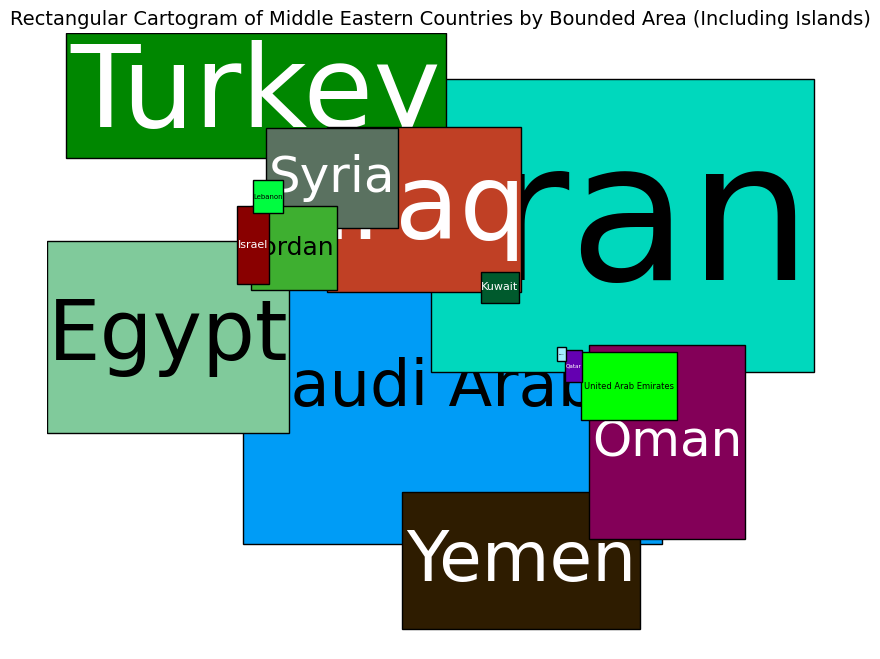

In [44]:

# Create a rectangular cartogram of middle eastern countries by bounded area (including islands)
import matplotlib.patches as patches
import webcolors

# Create the cartogram
fig, ax = plt.subplots(figsize=(12, 8))

# Initialize a base zorder for rectangles
base_zorder = 1

# Loop through countries and their properties
for (country_name, country_area) in country_areas:
    mask_series = countries_df.NAME_EN.isin([country_name])
    for (country_name, geometry), df in countries_df[mask_series].groupby(['NAME_EN', 'geometry']):
        bounds_tuple = geometry.bounds
            
        # Bounds Breakdown:
        minx = bounds_tuple[0]
        miny = bounds_tuple[1]
        maxx = bounds_tuple[2]
        maxy = bounds_tuple[3]
        
        # Rectangle Parameters:
        lower_left_corner = (minx, miny)
        width = maxx - minx
        height = maxy - miny
        
        # Add rectangle with current zorder
        facecolor = hex_color_dict[country_name]
        rect = patches.Rectangle(
            lower_left_corner, width, height,
            edgecolor="black",
            facecolor=facecolor,
            zorder=base_zorder,  # Current zorder for rectangle
        )
        ax.add_patch(rect)
    
        # Add country name with higher zorder than the rectangle
        rgb_tuple = tuple(webcolors.hex_to_rgb(facecolor))
        ax.text(
            minx + width / 2, miny + height / 2, country_name,
            alpha=1.0,
            color=get_text_color(rgb_tuple),
            fontsize=fontsize_dict[country_name],
            ha="center",
            va="center",
            zorder=base_zorder + 1,  # Higher than the current rectangle
        )

        # Increment base zorder for the next rectangle
        base_zorder += 1

# Adjust plot limits
mask_series = countries_df.NAME_EN.isin(country_names)
xlim_minx = countries_df[mask_series].geometry.map(lambda g: g.bounds[0]).min()
xlim_maxx = countries_df[mask_series].geometry.map(lambda g: g.bounds[2]).max()
ax.set_xlim(xlim_minx, xlim_maxx+1)
ylim_miny = countries_df[mask_series].geometry.map(lambda g: g.bounds[1]).min()
ylim_maxy = countries_df[mask_series].geometry.map(lambda g: g.bounds[3]).max()
ax.set_ylim(ylim_miny-1, ylim_maxy)
ax.set_aspect("equal")
plt.title("Rectangular Cartogram of Middle Eastern Countries by Bounded Area (Including Islands)", fontsize=14)
plt.axis("off")
plt.show()